Discrete events, such as binary or count data, are sometimes better understood when represented as continuous variables for visualization, analysis, and modeling. Python’s standard suite of data science libraries provide a number of functions to effect these transformations. In this post, we apply some very simple functions from the Pandas and Numpy libraries to transform neural spike train records from discrete events to continous firing rates in Hertz. 

The transformations described below demonstrate Python code that implements theoretical descriptions from *Theoretical Neuroscience* (Dayan & Abbott, 2001). We apply this code to spike train data provided through the book’s website hosted by University College of London: [Theoretical Neuroscience](http://www.gatsby.ucl.ac.uk/~dayan/book/exercises.html). The spike train recordings were collected by Rob de Ruyter van Steveninck and the recordings reflect action potentials from a fly H1 neuron in response to white noise stimuli. 

This post demonstrates methods for transforming discrete events to continuous representations as follows:
1. Code to download spike train data and bring it into your python workspace.
2. Visualization of the raw spike train data as discrete events using a rug plot.
3. Transformations of the spike train as firing rates (Hertz) over contiguous bins.
4. Transformations of the spike train using window functions (convolution methods) using rectangular, gaussian, and causal kernels.

**Libraries**<br>
We’ll need to load the following python libraries:

In [2]:
#### libraries
import urllib.request
import scipy.stats
import scipy.io
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

In [3]:
%matplotlib inline

**Downloading and formatting the data**<br>
We start by downloading and formatting the data using the `urllib` and `scipy` packages. With the `urllib` package we can open a connection to the remote web url where the data is stored. Once we have established a connection, we use the `.read()` method to load the data into our workspace. 

In [5]:
#### file paths - remote
url = 'http://www.gatsby.ucl.ac.uk/~dayan/book/exercises/c1/data/c1p8.mat' # remote data location

#### Load data
with urllib.request.urlopen(url) as remote_data_path:
    mat_data = remote_data_path.read()

The data loads as a `.mat` file, Matlab’s proprietary data format. To convert this to python, simply save the file to a convenient location on your local computer. Then load the data in native python formatting using the loadmat function from the `scipy.io` library.

In [7]:
#### file paths - local
mat_file_path = (
        r"C:\Users\Carlos\Dropbox\Documents\Documents\E-Books\Neuroscience/"
        "Dayan2001TheoreticalNeuroscience\Book Chapters\ch_1\c1p8.mat")

with open(mat_file_path, 'wb') as out_file:
    out_file.write(mat_data)

# convert to python
expirement_dc = scipy.io.loadmat(mat_file_path)

**Set up**<br>
From the book website, we learn that the observation period for the neural recording spanned twenty minutes, and the sampling rate over this period was 500 Hertz. This means that each observation of the sample represents a span of two milliseconds (2 ms). We will use this information to create a dataframe index.

In [8]:
#### set-up
exp_period = 20 # experiment duration in minutes
samp_rt = 500 # sampling rate in hertz
samp_pd = 1/samp_rt # sampling period in seconds
samp_ms_pd = samp_pd*1000 # sampling period in miliseconds
obs_index = exp_period*60*samp_rt

The data consist of a single spike train representing a 20 minute recording of neural spiking in fly H1 in response to white noise stimuli. These values along with metadata are read into our workspace as a python dictionary. The spike train observations and the white noise stimuli are values in the dictionary with keys labels as **rho** and **stim**, respectively. We extract them into a pandas dataframe using our observation index as follows:

In [9]:
# construct dataframe
data_dc = {k:list(np.ravel(expirement_dc[k])) for k in ['rho', 'stim']}
data0_df = pd.DataFrame(data_dc, index = [x*samp_ms_pd for x in range(obs_index)])
data_df = data0_df.loc[:3000-1] # filter first 3 seconds of data

Our dataframe has two columns and an index representing the time from the start of the observation period in milliseconds. For faster execution, we filter the dataframe to contain only the first three seconds of the sample.

**Data Transformations**<br>
*Rug plot*<br>
The rug plot will produce vertical lines at times supplied to the seaborn function `rugplot()`. We filter the dataframe to those times when a spike event occurred, and pass the index to the `rugplot()` function using the `.pipe()` method from the pandas library. Since we will soon stack our different visualizations vertically (see below), we extend the limits of the x-axis to the full three second interval.

The rugplot represents the data as discrete events over the sample period.

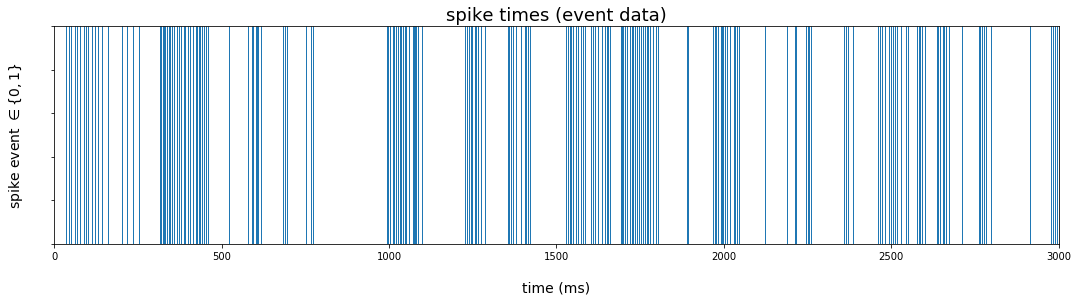

In [10]:
plt.figure(figsize=(18,4))
rug_pl = (
        data_df
        .loc[data_df.rho == 1] # extract time points where spike occurred
        .pipe(lambda df: sns.rugplot(df.index, height=1))
        )
rug_pl.set_title('spike times (event data)')
rug_pl.set_xlim(0,3000)
rug_pl.set_xlabel('time (ms)', labelpad=20)
rug_pl.set_ylabel(r'spike event $\in \lbrace 0,1 \rbrace$', labelpad=22)
rug_pl.set(yticklabels=[])
rug_pl.title.set_fontsize(18)
rug_pl.xaxis.label.set_fontsize(14)
rug_pl.yaxis.label.set_fontsize(14)

*Contiguous bins*<br>
We first transform the event data to Hertz using contiguous bins 100 ms in width. We again filter the data to those observations when a spike occurred and pass the index to seaborn's `distplot()` function. Since the level of the estimate reflects the count of spikes within a 100 ms bin, we need to divide the count by the bin width in order to estimate firing rate in Hertz. We do this by re-labeling the y-axis to the appropriate scale.


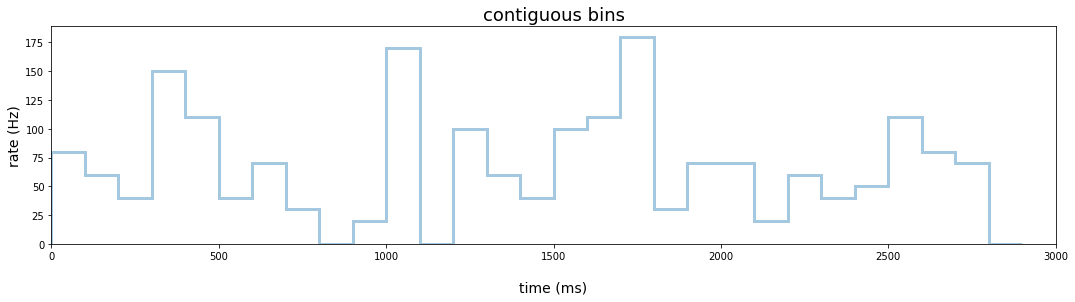

In [11]:
plt.figure(figsize=(18,4))
hist_pl = (
        data_df
        .loc[data_df.rho == 1] # extract time points where spike occurred
        .pipe(lambda df: 
              sns.distplot(df.index, 
                           bins = range(0, 3000, 100),
                           kde = False,
                           hist_kws={"histtype": "step", "linewidth": 3}))
        )
hist_pl.set_title('contiguous bins')
hist_pl.set_xlim(0,3000)
ylabels = [str(int(round(x))) for x in hist_pl.get_yticks()/.1]
hist_pl.set(yticklabels=ylabels)
hist_pl.set_xlabel('time (ms)', labelpad=20)
hist_pl.set_ylabel('rate (Hz)')
hist_pl.title.set_fontsize(18)
hist_pl.yaxis.label.set_fontsize(14)
hist_pl.xaxis.label.set_fontsize(14)

*Rectangular window*<br>
Instead of static contiguous bins that make the rate estimate highly dependent on the position of the bins, we could estimate firing rate using a sliding window across the span of our observation period. The rectangular window used with contiguous bins above is the simplest shape, but here we slide the window so that right and left boundaries move in step over the observation period. Transforming a function by sliding a window and integrating at each point is called *convolution*, and the shape of the window is called the *kernel*. 

In the case of a rectangular sliding window, we represent the estimate of the firing rate at time $t$ as $\hat r(t) = \sum_{i=1}^n{w(t-t_i)}$, where $t_i$ denotes the time of a spike event and:

$$
w(t-t_i) =  
\begin{cases} 
\frac{1}{\Delta t}, & -\frac{\Delta t}{2} \ge t-t_i \ge \frac{\Delta t}{2} \\
0, & \text{otherwise} 
\end{cases} 
\label{a}\tag{1}
$$

Computing convolution using window functions is very simple using pandas dataframe method `.rolling()`. The first parameter of the `.rolling()` method represents the width of the window; the center parameter is `True` if the window is centered; and `min_periods` parameter allows you to perform the estimation for intervals when the number of observations is smaller than the window width (ie., the window opens from one observation to the number specified by your window width near the beginning of your sample). The `.rolling()` method should be followed by an aggregation; in our case, we use the `.sum()` method to count the number of spikes at each centered window. 

A window of 51 gives 25 bins to either side of center. Since each bin equals 2 ms, the total window width is 102 ms. After counting spikes over this window at each time point, we divide by 51*(2ms) to get the estimated spikes per millisecond; then we divide further by 1ms (1/1000) to get rate in Hertz.

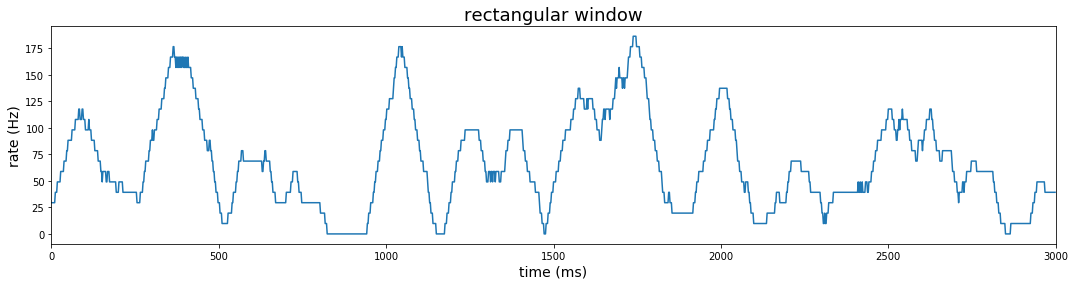

In [12]:
#### window method: rectangular
plt.figure(figsize=(18,4))
win_pd = int(samp_ms_pd*25+1)
rect_win_pl = (
        data_df
        .loc[:, 'rho']
        .rolling(win_pd, center=True, min_periods=1).sum()
        .transform(lambda x: np.divide(x, 51))
        .transform(lambda x: np.divide(x, samp_pd))
        .reset_index(level=0)
        .pipe(lambda df: sns.lineplot(x='index', y='rho', data = df))
 )
rect_win_pl.set_title('rectangular window')
rect_win_pl.set_xlim(0,3000)
rect_win_pl.set_xlabel('time (ms)')
rect_win_pl.set_ylabel('rate (Hz)')
rect_win_pl.title.set_fontsize(18)
rect_win_pl.yaxis.label.set_fontsize(14)
rect_win_pl.xaxis.label.set_fontsize(14)

*Gaussian window*<br>
We use a gaussian kernel for smoother rate estimates. This firing rate is estimated as:

$$ 
\begin{eqnarray} 
\hat r(t) &=& \sum_{i=1}^{n} \frac{1}{\sqrt{2 \pi \sigma}} \exp \left(\frac{-(t-t_i)^2}{2 \sigma ^2}\right) 
\end{eqnarray} 
\label{b}\tag{2}
$$

The gaussian window width should be as large as the data since the gaussian is supported from negative infinity to positive infinity. The `.rolling()` method with a gaussian kernel requires a standard deviation (std) argument in the `.sum()` method to determine the width of the window. 

The rolling method with `win_type = 'gaussian'` produces an unnormalized gaussian sum. That is, the weight of each observation falls off according to the gaussian pdf, but the area under the curve does not sum to 1. The parameter representing std should be adjusted according to the resolution of the sampling rate. We can apply the normalization after summing (in this case using the unadjusted std). The sum after normalization represents the estimated firing rate at each 2ms bin. To get the rate in Hertz, we divide further by the duration of the bin (2ms)


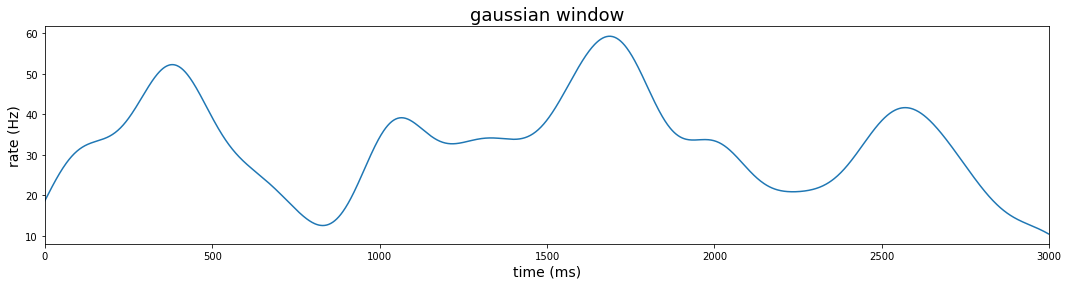

In [13]:
#### window method: gaussian
plt.figure(figsize=(18,4))
sigma = 100
adj_sigma = sigma/samp_ms_pd
gauss_win_pl = (
    data_df
    .loc[:, 'rho']
    .rolling(3000, center=True, min_periods=1, win_type='gaussian')
    .sum(std = adj_sigma)
    .transform(lambda x: np.divide(x, np.sqrt(2*np.pi)*sigma))
    .transform(lambda x: np.divide(x, samp_pd))
    .reset_index(level=0)
    .pipe(lambda df: sns.lineplot(x='index', y='rho', data = df)))
gauss_win_pl.set_title('gaussian window')
gauss_win_pl.set_xlim(0,3000)
gauss_win_pl.set_xlabel('time (ms)')
gauss_win_pl.set_ylabel('rate (Hz)')
gauss_win_pl.title.set_fontsize(18)
gauss_win_pl.yaxis.label.set_fontsize(14)
gauss_win_pl.xaxis.label.set_fontsize(14)

*Causal kernel (alpha function)*<br>
Lastly, we consider a causal kernel that estimates the firing rate at each time point using only information available from samples prior to the estimated time. In this case, we first define a new function alpha_fn. The function’s call signature includes the event data to be transformed, the sampling period, and a parameter to control the window width. More precisely, the alpha function is defined as $w(\tau) = [\alpha^2 \tau \exp (-\alpha \tau)]_{+}$. Using this window, the firing rate is estimated as: 

$$ 
\hat r(t) = \sum_{i=1}^{n} [\alpha^2 (t-t_i) \exp (-\alpha (t-t_i))]_{+}
\label{3}\tag{3}
$$

We code this function in python as:

In [14]:
def alpha_fn(x, samp_pd, alpha_bin):
        spike_times = x.nonzero()[0]*samp_pd
        t = len(x)*samp_pd-1
        r_alpha_t = sum(
                (alpha_bin**2)*\
                (t - spike_times)*\
                np.exp(-alpha_bin*(t - spike_times))
                )
        return r_alpha_t

To use this function, we call the rolling method as before, but we no longer center the kernel about the point to be estimated. Instead of using the `.sum()` method, we use the `.apply()` method with a call to our custom alpha function. As with the gaussian kernel, we will need to divide the result by the sample period in order to recover our rate in Hertz.

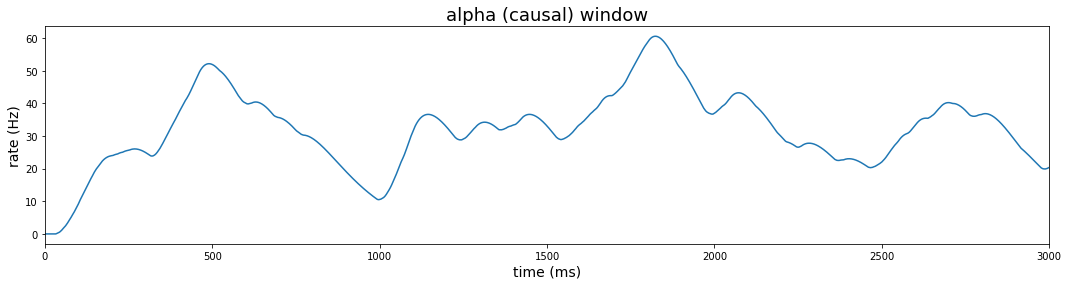

In [15]:
#### window method: alpha (causal kernel)
plt.figure(figsize=(18,4))

alpha = 1/100 # window width parameter in ms (1/alpha = 100 ms)
alpha_win_pl = (
    data_df
    .loc[:, 'rho']
    .rolling(3000, center=False, min_periods=1)
    .apply(lambda x: alpha_fn(x, samp_ms_pd, alpha_bin = alpha), raw=True)
    .transform(lambda x: np.divide(x, samp_pd))
    .reset_index(level=0)
    .pipe(lambda df: sns.lineplot(x='index', y='rho', data = df)
        )
 )
alpha_win_pl.set_title('alpha (causal) window')
alpha_win_pl.set_xlabel('time (ms)')
alpha_win_pl.set_xlim(0,3000)
alpha_win_pl.set_ylabel('rate (Hz)')
alpha_win_pl.title.set_fontsize(18)
alpha_win_pl.yaxis.label.set_fontsize(14)
alpha_win_pl.xaxis.label.set_fontsize(14)

We can more easily compare these different methods by stacking these plots.

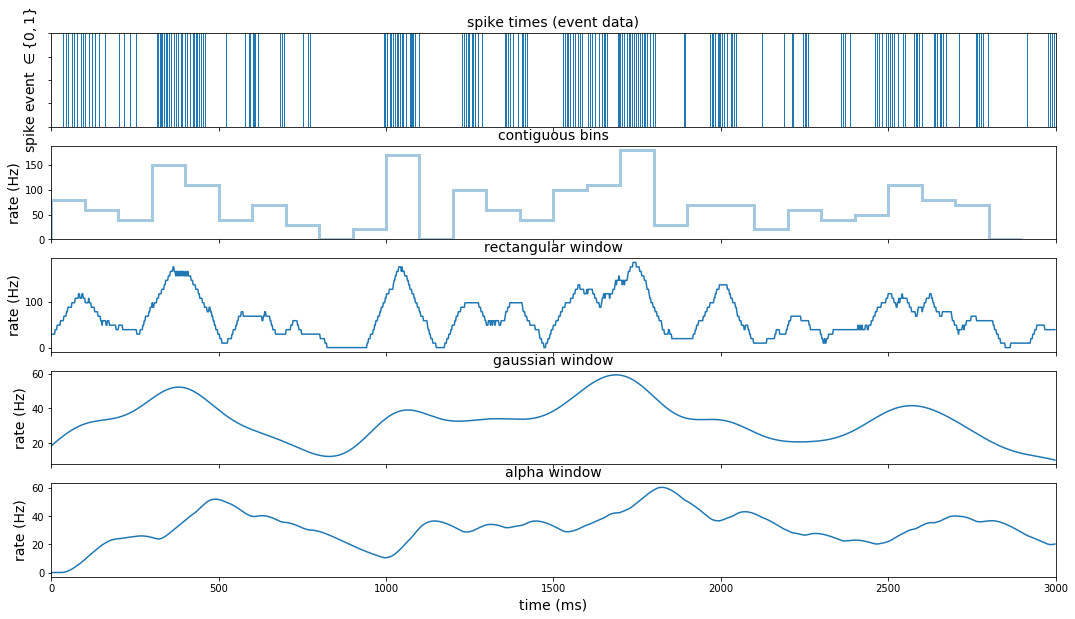

In [18]:
#### transformations and visualizations
fig, axes_ls = plt.subplots(nrows=5, ncols=1, sharex=False, sharey=False, figsize=(18,10))

#### visualize spike train with rug plot
rug_pl = (
        data_df
        .loc[data_df.rho == 1] # extract time points where spike occurred
        .pipe(lambda df: sns.rugplot(df.index, height=1, ax = axes_ls[0]))
        )
rug_pl.set_title('spike times (event data)')
rug_pl.set_xlim(0,3000)
rug_pl.set_ylabel(r'spike event $\in \lbrace 0,1 \rbrace$')
rug_pl.set(yticklabels=[])

#### binning method:
hist_pl = (
        data_df
        .loc[data_df.rho == 1] # extract time points where spike occurred
        .pipe(lambda df: sns.distplot(df.index, 
                                      bins = range(0, 3000, 100),
                                      kde = False,
                                      hist_kws={"histtype": "step",
                                                "linewidth": 3},
                                      ax = axes_ls[1]))
        )
hist_pl.set_title('contiguous bins')
hist_pl.set_xlim(0,3000)
ylabels = [str(int(round(x))) for x in hist_pl.get_yticks()/.1]
hist_pl.set(yticklabels=ylabels)
hist_pl.set_ylabel('rate (Hz)')

#### window method: rectangular
win_pd = int(samp_ms_pd*25+1)
rect_win_pl = (
        data_df
        .loc[:, 'rho']
        .rolling(win_pd, center=True, min_periods=1).sum()
        .transform(lambda x: np.divide(x, 51))
        .transform(lambda x: np.divide(x, samp_pd))
        .reset_index(level=0)
        .pipe(lambda df: sns.lineplot(x='index', y='rho', 
                                      data = df,
                                      ax = axes_ls[2]
                                      ))
 )
rect_win_pl.set_title('rectangular window')
rect_win_pl.set_xlim(0,3000)
rect_win_pl.set_ylabel('rate (Hz)')

#### window method: gaussian
gauss_win_pl = (
        data_df
        .loc[:, 'rho']
        .rolling(3000, center=True, min_periods=1,
                 win_type='gaussian').sum(std = adj_sigma)
        .transform(lambda x: np.divide(x, np.sqrt(2*np.pi)*sigma))
        .transform(lambda x: np.divide(x, samp_pd))
        .reset_index(level=0)
        .pipe(lambda df: sns.lineplot(x='index', y='rho', 
                                      data = df, 
                                      ax = axes_ls[3]
                                      ))
        )
gauss_win_pl.set_title('gaussian window')
gauss_win_pl.set_xlim(0,3000)
gauss_win_pl.set_ylabel('rate (Hz)')

#### window method: alpha (causal kernel)    
alpha_win_pl = (
        data_df
        .loc[:, 'rho']
        .rolling(3000, center=False, min_periods=1)
        .apply(lambda x: alpha_fn(x, samp_ms_pd, alpha_bin = alpha), raw=True)
        .transform(lambda x: np.divide(x, samp_pd))
        .reset_index(level=0)
        .pipe(lambda df: sns.lineplot(x='index', y='rho', 
                                      data = df, 
                                      ax = axes_ls[4]
                                      )
        )
 )
alpha_win_pl.set_title('alpha window')
alpha_win_pl.set_xlabel('time (ms)')
alpha_win_pl.set_xlim(0,3000)
alpha_win_pl.set_ylabel('rate (Hz)')
alpha_win_pl.xaxis.label.set_fontsize(14)

pl_ls = [rug_pl, hist_pl, rect_win_pl, gauss_win_pl, alpha_win_pl]
_ = [pl.title.set_fontsize(14) for pl in pl_ls]
_ = [pl.yaxis.label.set_fontsize(14) for pl in pl_ls]
_ = [pl.set_xlabel('') for pl in pl_ls[:-1]]
_ = [pl.set(xticklabels=[]) for pl in pl_ls[:-1]]